# Detector Hits

Demonstrate the total number of hits in the IceCube detector after implementaing neutrino oscillations.

In [1]:
from astropy import units as u

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from asteria import config, source, interactions, detector
from asteria.neutrino import Flavor
from asteria.oscillation import SimpleMixing

mpl.rc('font', size=16)

## Load Configuration

This will load the source configuration from a file.

For this to work, either the user needs to have done one of two things:
1. Run `python setup.py install` in the ASTERIA directory.
2. Run `python setup.py develop` and set the environment variable `ASTERIA` to point to the git source checkout.

If these were not done, the initialization will fail because the paths will not be correctly resolved.

In [2]:
conf = config.load_config('../../data/config/test-Copy1.yaml')
ccsn = source.initialize(conf)
ic86 = detector.initialize(conf)

## Prepare Iterables

Define the range of neutrino energies (`E_nu`) to simulate and the times (`time`) and distances (`dist`) at which to perform the simulation. 

In [3]:
E_min = 0.1; E_max = 100.1; dE = 0.1;
Enu = np.arange(E_min, E_max, dE) * u.MeV

t_min = -1; t_max = 15; dt = 0.0001;
time = np.arange(t_min, t_max, dt) * u.s

d_min = 1; d_max = 31; dd = 1;
dist = np.arange(d_min, d_max, dd) * u.kpc

## Define Background and Deadtime

The background detected by IceCube is given by `dr`+`dr_er`


In [4]:
dr = 2933.72
dr_er = 85.8662

icecube_dt = 2e-3 #s
deadtime = 0.25e-3
dc_rel_eff = 1.35

## Redefine `photonic_energy_per_volume`

`photonic_energy_per_volume` is originally defined in the `source.py` module. The function signature has been modified for the purposes of this program to read in the neutrino flux for each flavor as an ndarray to account for flavor mixing, as opposed to calculcing it using `source.get_flux(time, flavor)`.

In [5]:
def photonic_energy_per_vol(source, time, E, flavor, photon_spectrum, flux_list, n=1000):
        """Compute the energy deposited in a cubic meter of ice by photons
        from SN neutrino interactions.

        Parameters
        ----------

        time : float (units s)
            Time relative to core bounce.            
        E : `numpy.ndarray`
            Sorted grid of neutrino energies
        flavor : :class:`asteria.neutrino.Flavor`
            Neutrino flavor.
        photon_spectrum : `numpy.ndarray` (Units vary, m**2)
            Grid of the product of lepton cross section with lepton mean energy
            and lepton path length per MeV, sorted according to parameter E
        n : int
            Maximum number of time steps to compute at once. A temporary numpy array
            of size n x time.size is created and can be very memory inefficient.

        Returns
        -------
        E_per_V
            Energy per m**3 of ice deposited  by neutrinos of requested flavor
        """
        H2O_in_ice = 3.053e28 # 1 / u.m**3
                
        t = time.to(u.s).value
        Enu = E.to(u.MeV)
        if Enu[0] == 0:
            Enu[0] = 1e-10 * u.MeV
        phot = photon_spectrum.to(u.m**2).value.reshape((-1,1)) # m**2
        
        dist = source.progenitor_distance.to(u.m).value # m**2
#         flux = source.get_flux( time, flavor ) # Unitless
        flux = flux_list
        if not flavor.is_electron:
            flux *= 2
        
        print('Beginning {0} simulation....'.format(flavor._name_), end='')
        # The following two lines exploit the fact that astropy quantities will
        # always return a number when numpy size is called on them, even if it is 1.
        E_per_V =  np.zeros( time.size ) 
        for i_part in source.parts_by_index(time, n): # Limits memory usage
            E_per_V[i_part] += np.trapz( source.energy_spectrum(t[i_part], Enu, flavor) * phot, Enu.value, axis=0)
        E_per_V *= flux * H2O_in_ice / ( 4 * np.pi * dist**2)
        print('Completed')
    
        return E_per_V * u.MeV / u.m**3


## Compute Charged Particle Spectrum

Compute the number of photons produced by $\nu$ component interactions with charged particles given neutrino flavor and energy. `Interactions` contains a list of the interactions that are simulated. This list may be changed to turn 'off/on' specific interactions

The interactions are as follows:
- `InvBetaTab` : Tabulated inverse beta decay computation by Strumia and Vissani, Phys. Lett. B 564:42, 2003.
  - See Also: `InvBetaPar` : Inverse beta decay parameterization
- `ElectronScatter` : Elastic Neutrino-electron scattering from Marciano and Parsa, J. Phys. G 29:2969, 2003.
- `Oxygen16CC` : $\nu$-$^{16}O$ charged current interaction, using estimates from Kolbe et al., PRD 66:013007, 2002.
- `Oxygen16NC` : $\nu$-$^{16}O$ neutral current interaction, using estimates from Kolbe et al., PRD 66:013007, 2002.
- `Oxygen18` : $\nu$-$^{18}O$ charged current interaction, using estimates from Kamiokande data from Haxton and Robertson, PRC 59:515, 1999.

These `Interaction` objects may be used to compute the neutrino cross sections and mean energy of the produced lepton, both as a function of neutrino energy. The final state lepton energy has been integrated out. This cross section with a component of $H_2O$ is then scaled as appropriate for a $H_2O$ molecule (IE Electron scattering cross section is scaled by 10, as there are 10 electrons in $H_2O$).

`photons_per_lepton_MeV` is computed by finding number of photon emitted per unit lepton path length and multiplying it by the lepton path length per MeV. This is done using the Frank-Tamm formula and index of refraction from Price and Bergstrom, AO 36:004181, 1997.

Then, the product of the cross section, mean lepton energy and `photons_per_lepton_MeV` is taken to estimate the number of photons as a function of neutrino energy. It will have units $m^2$ at the end of this cell but is later scaled by the $r^2$ where $r$ is the progenitor distance, accounting for losses.

NOTE: In the case of `ElectronScatter`, the mean energy is the integrated product of the differential cross section and mean energy, this was done analytically.

In [6]:
# Define which interactions will be considered
Interactions = [interactions.InvBetaPar(),
                interactions.ElectronScatter(),
                interactions.Oxygen16CC(),
                interactions.Oxygen16NC(),
                interactions.Oxygen18()]

# Initialize array for the spectra of photons produced by each neutrino flavor
photon_spectra = np.zeros( shape=(len(Flavor), Enu.size) )

for nu, flavor in enumerate(Flavor):
    for interaction in Interactions: 
        
        xs    = interaction.cross_section(flavor, Enu).to(u.m**2).value
        E_lep = interaction.mean_lepton_energy(flavor, Enu).value
        
        photons_per_lepton_MeV = interaction.photons_per_lepton_MeV.value # 1/ u.MeV
        
        if isinstance(interaction, interactions.ElectronScatter):
            xs = np.ones_like(xs)
            E_lep = interaction.mean_lepton_energy(flavor, Enu).to(u.m**2 * u.MeV).value 

        elif isinstance(interaction, (interactions.InvBetaTab,
                                      interactions.Oxygen16CC,
                                      interactions.Oxygen18)):
            if flavor == Flavor.nu_e_bar:
                photons_per_lepton_MeV *= interaction.p2e_path_ratio

        photon_spectra[nu] +=  xs * E_lep * photons_per_lepton_MeV # u.m**2 
    
photon_spectra *= u.m**2 

## Define Helper Functions

In [7]:
def hits(nu_list):
    '''Compute the number of hits generated in the detector for a given list of fluxes.
    
    Parameter
    ---------
    nu_list: ndarray
        List of neutrino flavors, ordered by default as nu_e, nu_e_bar, nu_x, nu_x_bar
    
    Returns
    -------
    hits: ndarray
        Number of hits in the detector
    '''
    signal = np.zeros( shape=(len(Flavor), time.size) )
    hits = np.zeros( shape=(len(Flavor), time.size) )
    
    for nu, (flavor, photon_spectrum) in enumerate(zip(Flavor, photon_spectra)):
        signal[nu] = photonic_energy_per_vol(ccsn, time, Enu, flavor, photon_spectrum, nu_list[nu])

    eps_i3 = 0.87 / (1+deadtime*np.sum( signal, axis=0)/icecube_dt)
    eps_dc = 0.87 / (1+deadtime*np.sum( signal, axis=0)*dc_rel_eff/icecube_dt)

    hits = ic86.detector_hits(abs(signal), eps_i3, eps_dc)
    return hits

In [8]:
def rebin(var, data, old_binning, new_binning):
    step = int(new_binning/old_binning)
    new_size = int(data.size / step)
    
    rebinned_data = np.sum(np.split( data, new_size ), axis=1)
    rebinned_var  = var.value[int(0.5 * step)::step]   
    
    return rebinned_var, rebinned_data

## Implementing Neutrino Oscillations

Fluxes for each flavor are calculted for normal and inverted mixing using the class `SimpleMixing` in the `neutrino.py` module.

$\theta_{12} = 33.82^{\circ}$ is used to initialize an object `mix` of `SimpleMixing`.

In [128]:
nu_list = np.zeros(shape = (4, 160000))
mix = SimpleMixing(33.82)

# data = np.zeros(shape = (30, 3, 160000))
# data[0][0] = time
# print(data)
# print(len(data))
# print(len(dist))
# data = dist
# print(data)
# for d in dist:
#     x = int(d.value) - 1
#     data[x][2] = time
# print(data)
# osc_data = np.zeros(shape = (3, 4, 8000))
# osc_data = []
# osc_data[0][0] = time
# osc_data[0][1]=time
# print(osc_data)
# dat1 = []
# dat2 = []
# data = []
# for i in range(4):
#     osc_data[0][i] = time
#     dats.append(osc_data)
# np.asarray(dats)
# print(dats)

In [109]:
# # f = open("bla.", "wb")
# for d in dist:
#     x = int(d.value)-1
# #     osc_data = np.zeros(shape = (3, 4, 160000))
#     osc_data = []
#     print('iteration', x+1)
#     for nu, flavor in enumerate(Flavor):
#         osc_data[0][nu] = time
# #         print(osc_data)
# #     print('total comp')
#     for nu, flavor in enumerate(Flavor):
#         osc_data[1][nu] = time
# #         print(osc_data)
# #     print('norm comp') 
#     for nu, flavor in enumerate(Flavor):
#         osc_data[2][nu] = time
# #         print(osc_data)
# #     print('inv comp')
#     dats.append(osc_data)
# np.asarray(dats)
# print(dats[29])


Calculating for 1.0 kpc...

Beginning nu_e simulation....Completed
Beginning nu_e_bar simulation....Completed
Beginning nu_x simulation....Completed
Beginning nu_x_bar simulation....Completed
Beginning nu_e simulation....Completed
Beginning nu_e_bar simulation....Completed
Beginning nu_x simulation....Completed
Beginning nu_x_bar simulation....Completed
Beginning nu_e simulation....Completed
Beginning nu_e_bar simulation....Completed
Beginning nu_x simulation....Completed
Beginning nu_x_bar simulation....Completed

Calculating for 2.0 kpc...

Beginning nu_e simulation....Completed
Beginning nu_e_bar simulation....Completed
Beginning nu_x simulation....Completed
Beginning nu_x_bar simulation....Completed
Beginning nu_e simulation....Completed
Beginning nu_e_bar simulation....Completed
Beginning nu_x simulation....Completed
Beginning nu_x_bar simulation....Completed
Beginning nu_e simulation....Completed
Beginning nu_e_bar simulation....Completed
Beginning nu_x simulation....Completed
B

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)



Calculating for 12.0 kpc...

Beginning nu_e simulation....Completed
Beginning nu_e_bar simulation....Completed
Beginning nu_x simulation....Completed
Beginning nu_x_bar simulation....Completed
Beginning nu_e simulation....Completed
Beginning nu_e_bar simulation....Completed
Beginning nu_x simulation....Completed
Beginning nu_x_bar simulation....Completed
Beginning nu_e simulation....Completed
Beginning nu_e_bar simulation....Completed
Beginning nu_x simulation....Completed
Beginning nu_x_bar simulation....Completed

Calculating for 13.0 kpc...

Beginning nu_e simulation....Completed
Beginning nu_e_bar simulation....Completed
Beginning nu_x simulation....Completed
Beginning nu_x_bar simulation....Completed
Beginning nu_e simulation....Completed
Beginning nu_e_bar simulation....Completed
Beginning nu_x simulation....Completed
Beginning nu_x_bar simulation....Completed
Beginning nu_e simulation....Completed
Beginning nu_e_bar simulation....Completed
Beginning nu_x simulation....Completed

Beginning nu_e simulation....Completed
Beginning nu_e_bar simulation....Completed
Beginning nu_x simulation....Completed
Beginning nu_x_bar simulation....Completed

Calculating for 28.0 kpc...

Beginning nu_e simulation....Completed
Beginning nu_e_bar simulation....Completed
Beginning nu_x simulation....Completed
Beginning nu_x_bar simulation....Completed
Beginning nu_e simulation....Completed
Beginning nu_e_bar simulation....Completed
Beginning nu_x simulation....Completed
Beginning nu_x_bar simulation....Completed
Beginning nu_e simulation....Completed
Beginning nu_e_bar simulation....Completed
Beginning nu_x simulation....Completed
Beginning nu_x_bar simulation....Completed

Calculating for 29.0 kpc...

Beginning nu_e simulation....Completed
Beginning nu_e_bar simulation....Completed
Beginning nu_x simulation....Completed
Beginning nu_x_bar simulation....Completed
Beginning nu_e simulation....Completed
Beginning nu_e_bar simulation....Completed
Beginning nu_x simulation....Completed

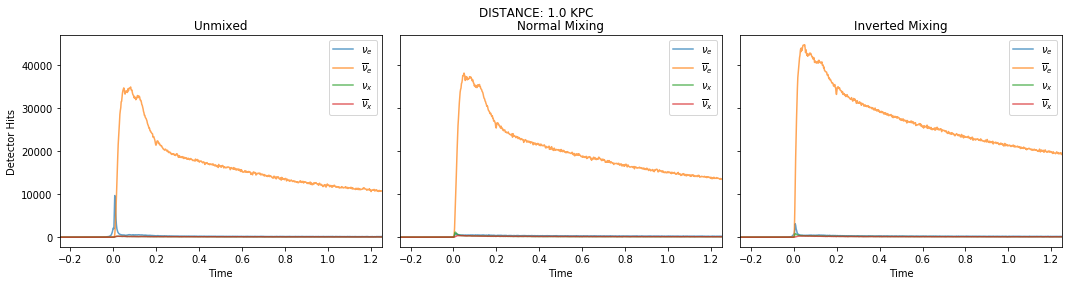

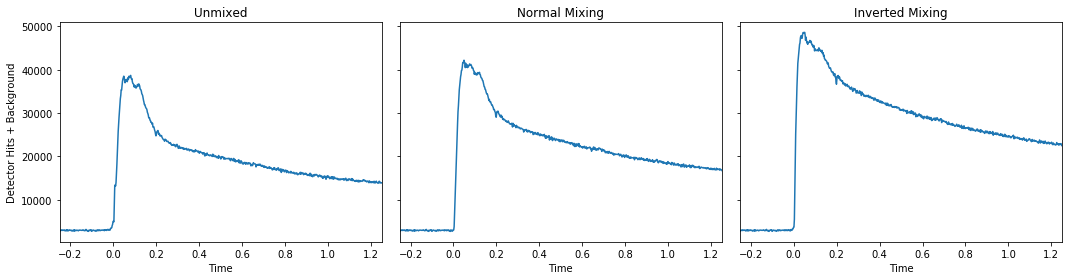

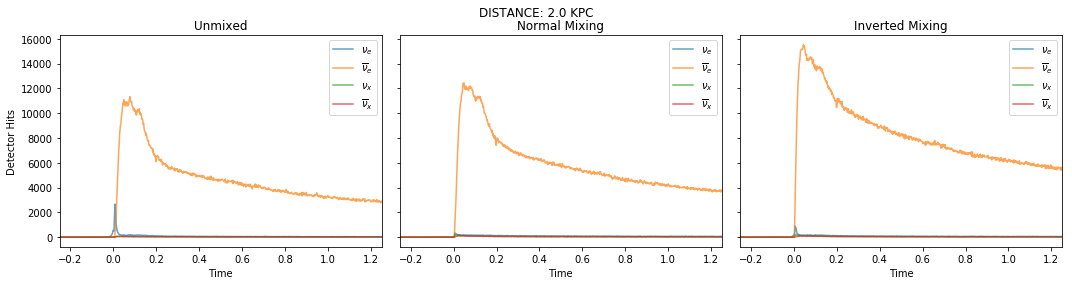

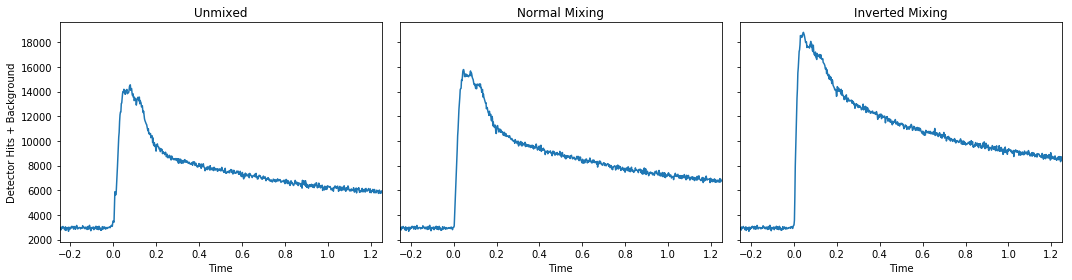

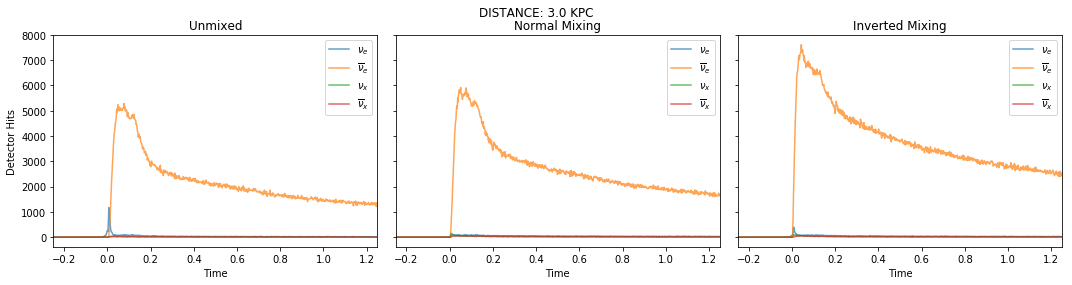

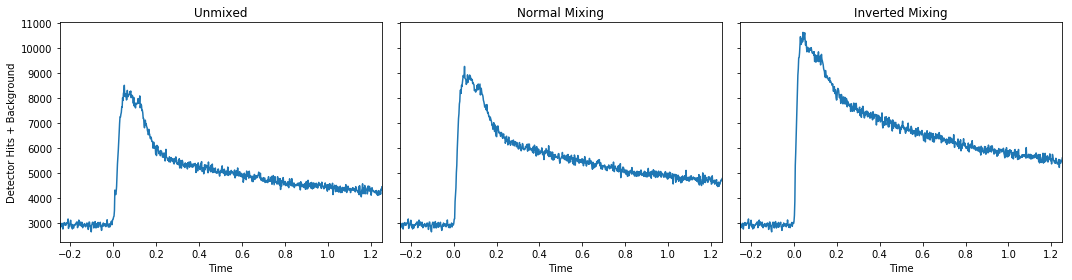

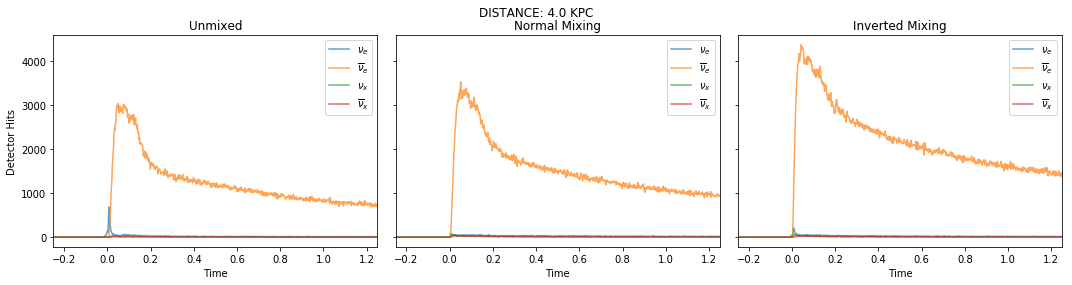

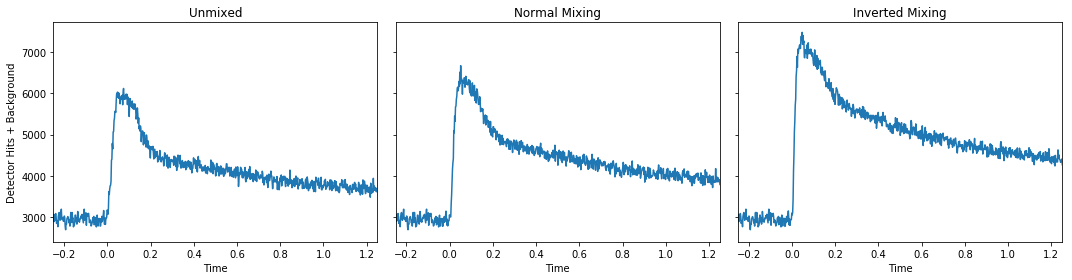

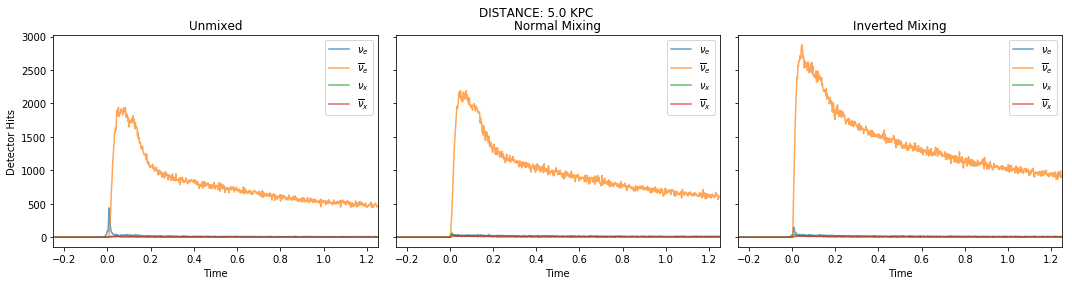

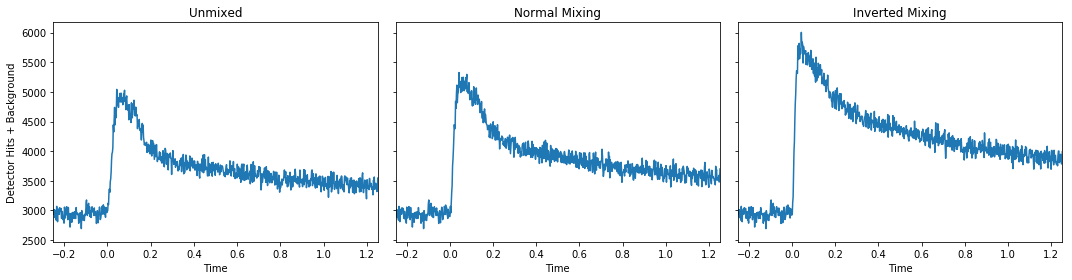

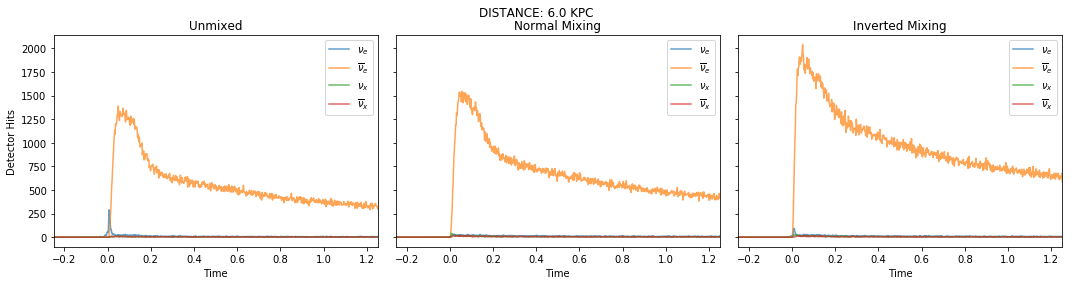

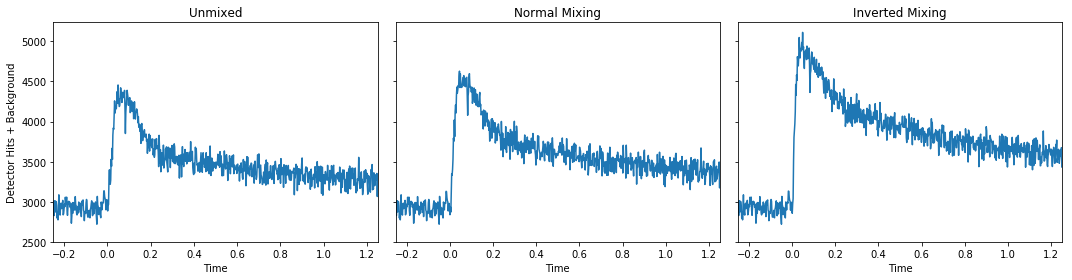

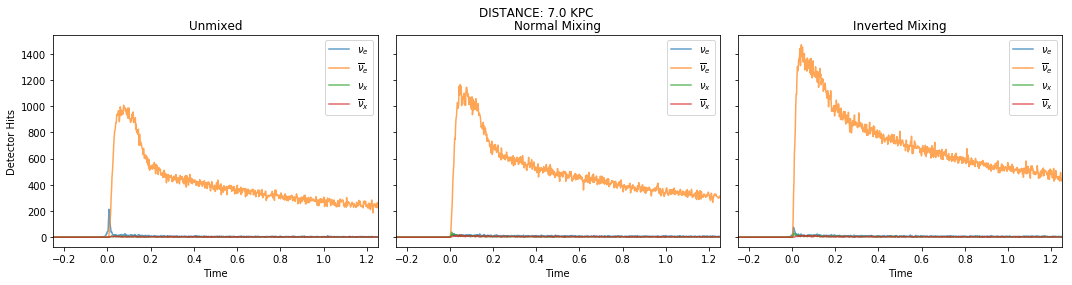

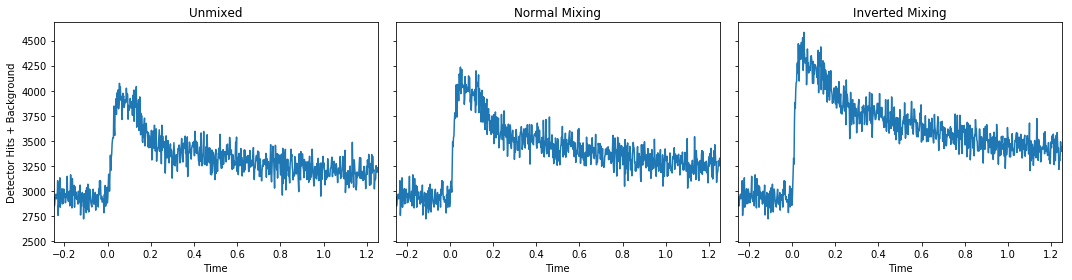

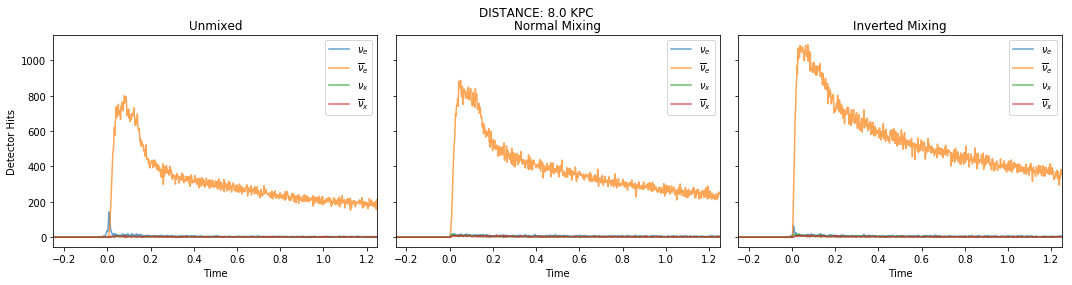

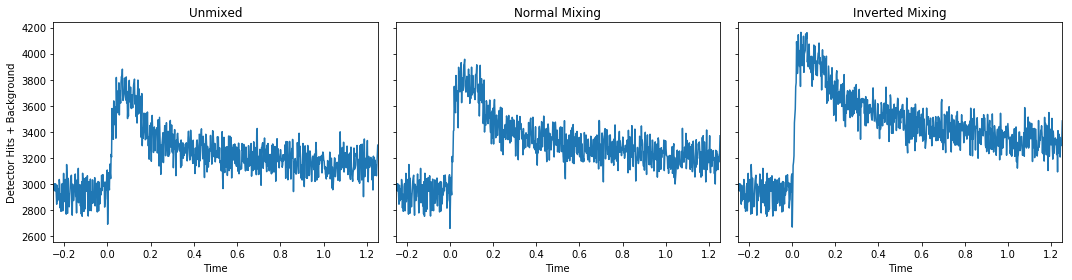

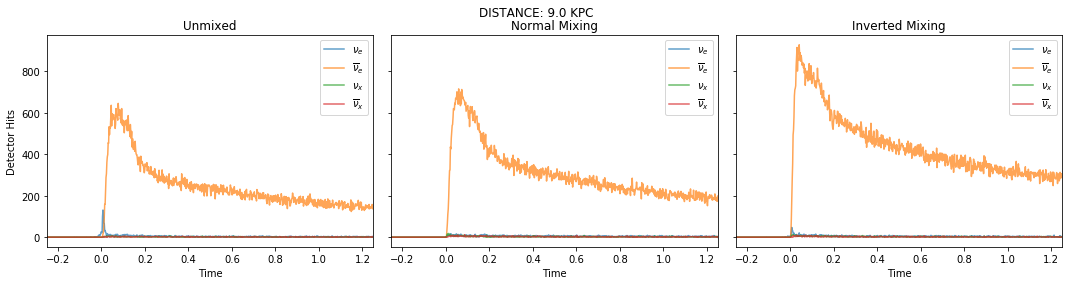

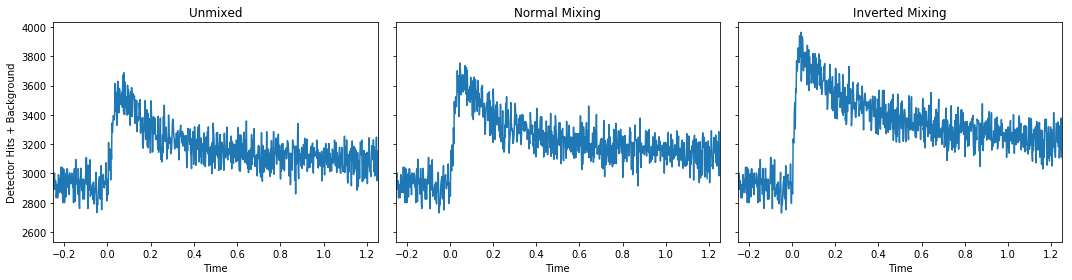

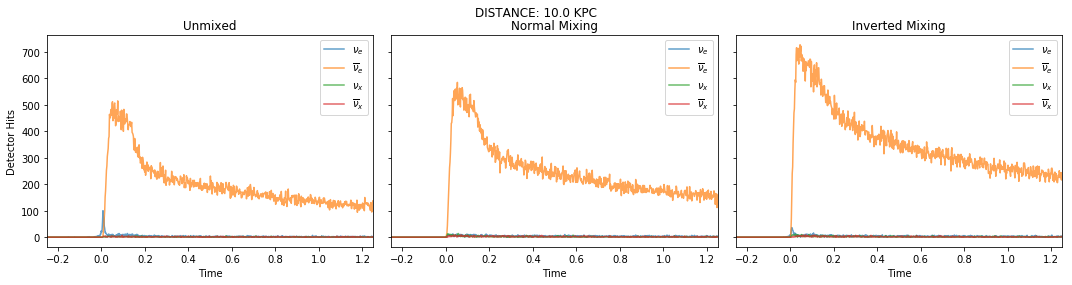

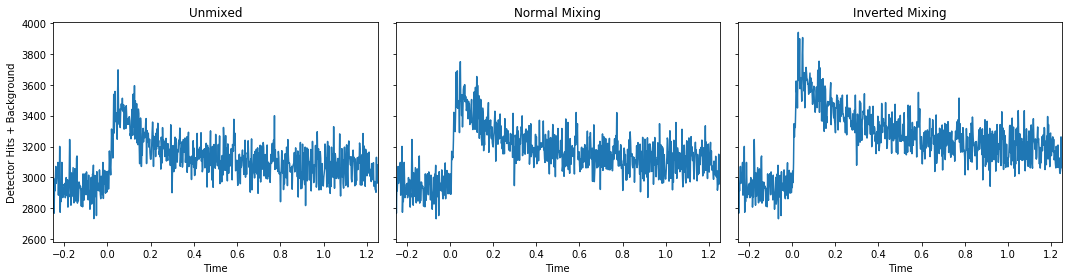

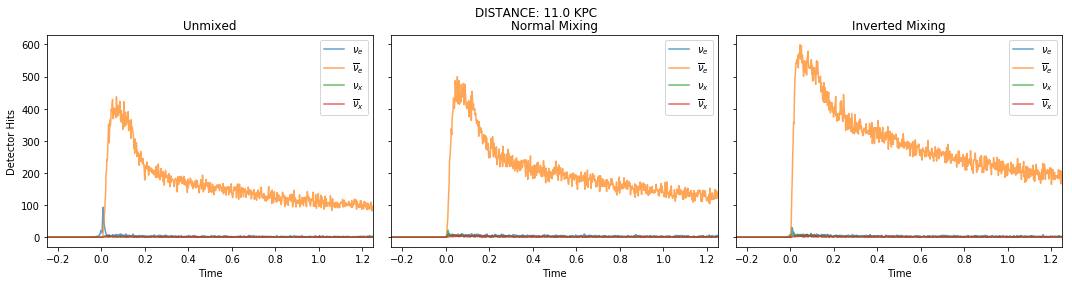

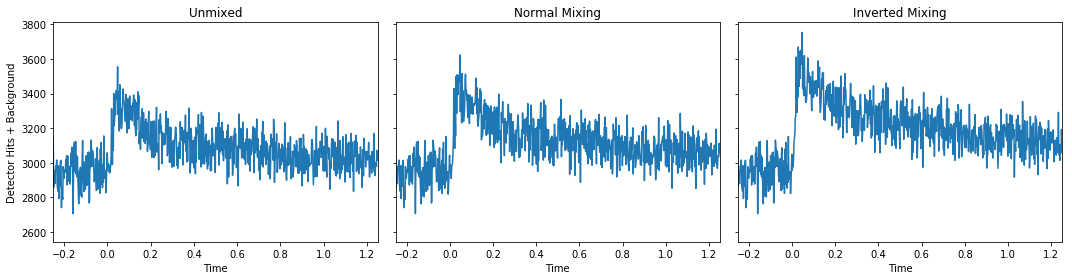

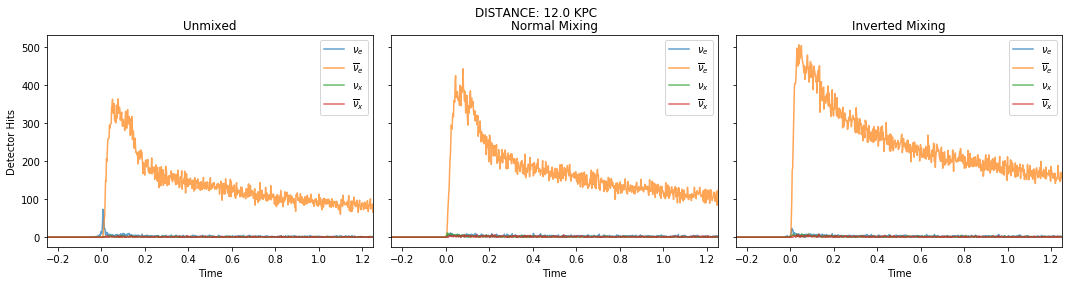

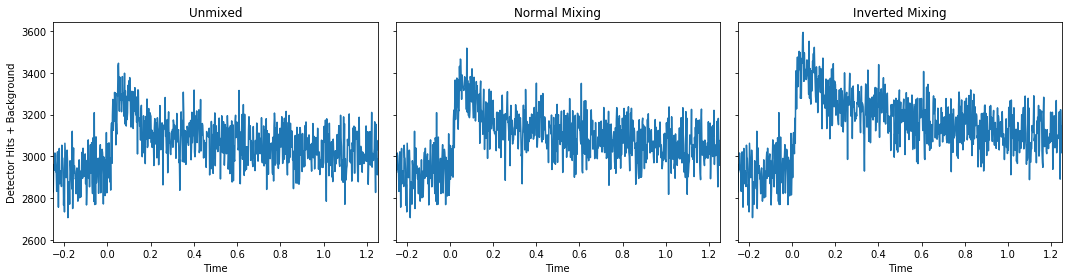

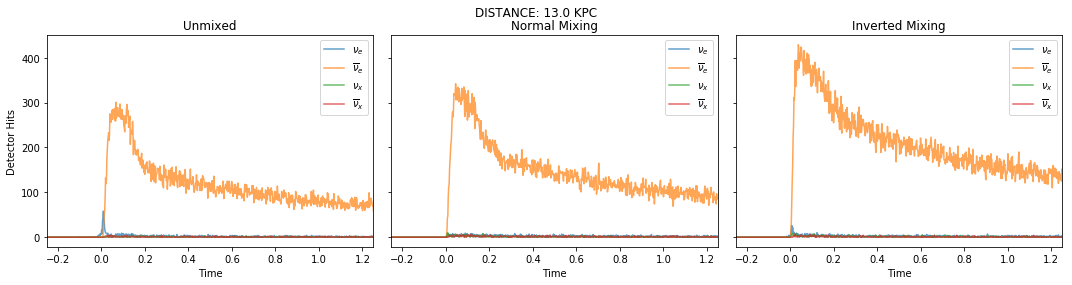

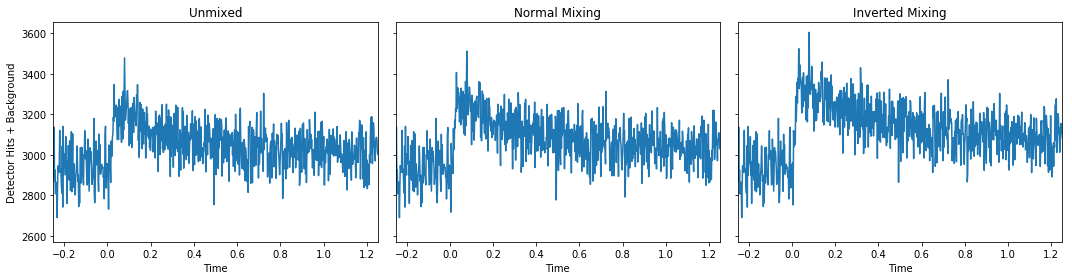

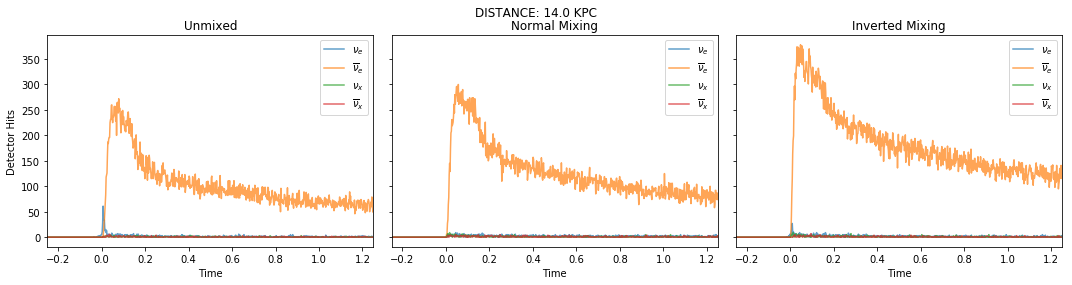

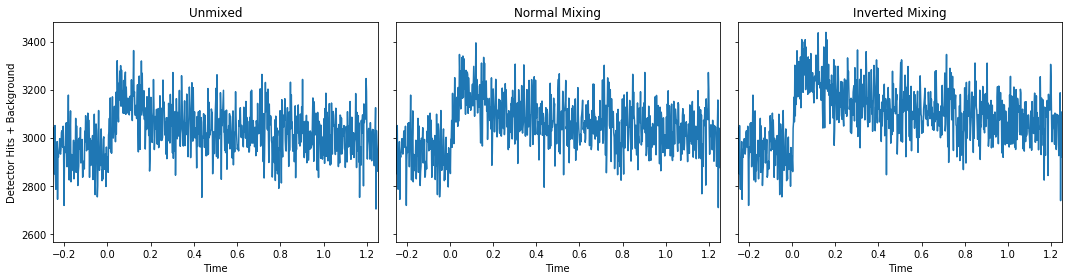

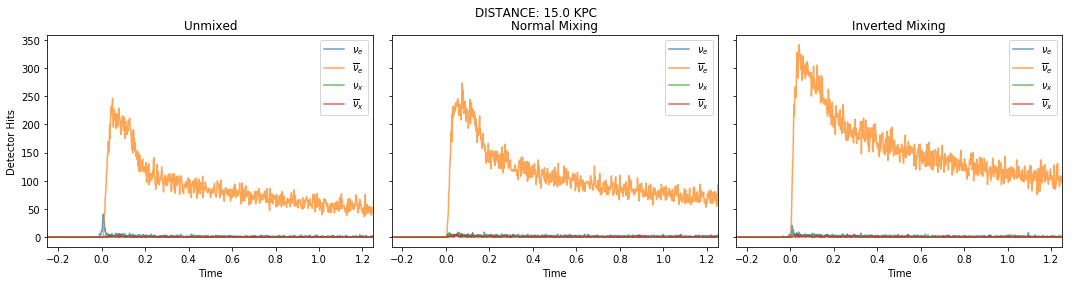

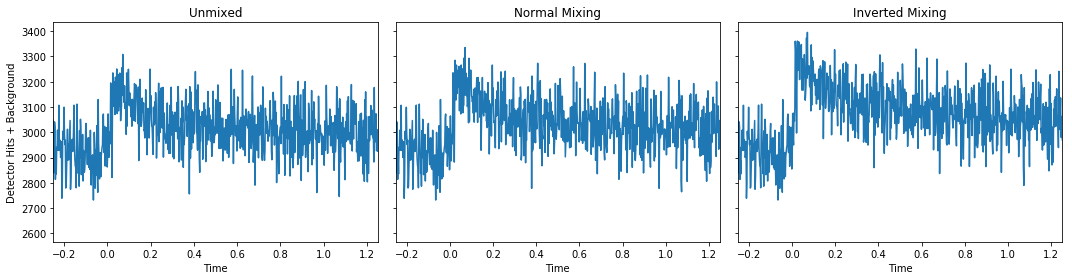

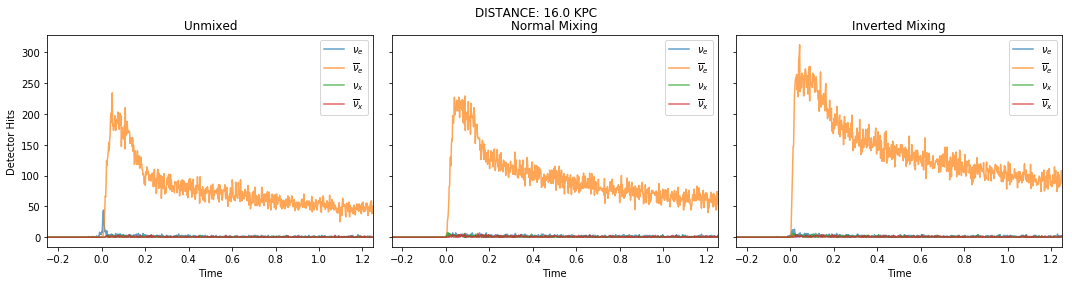

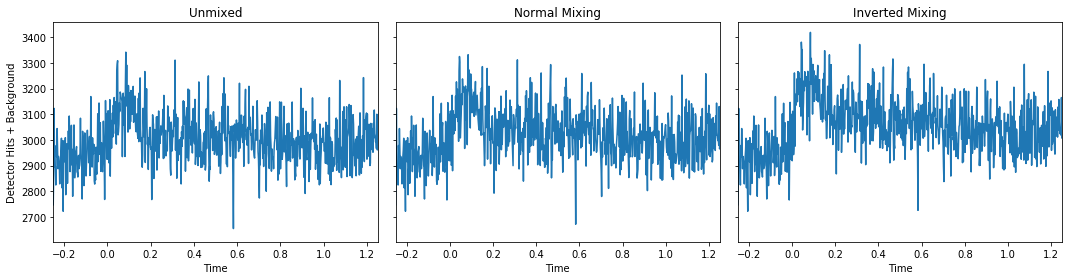

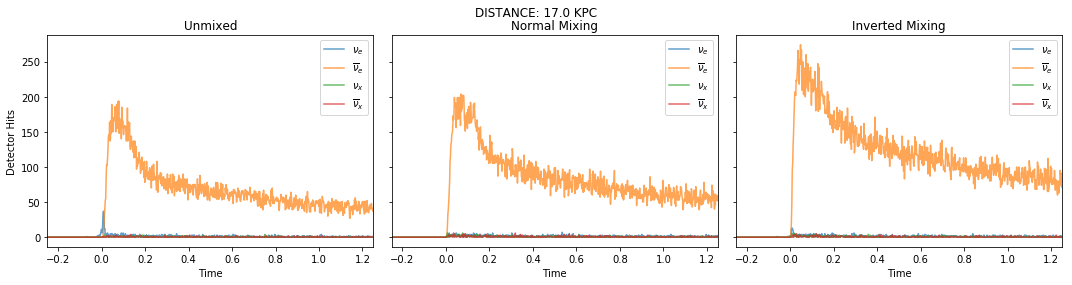

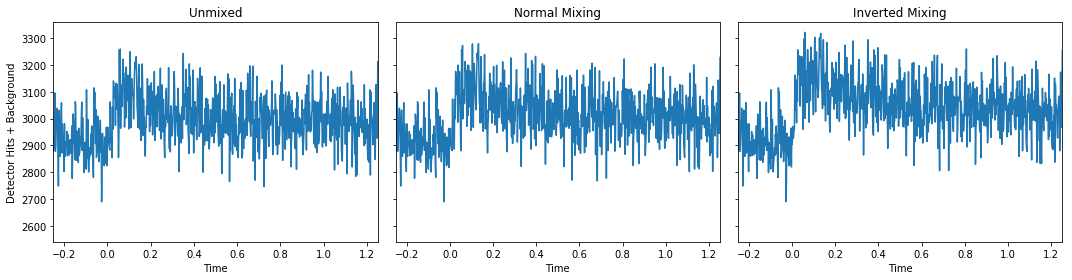

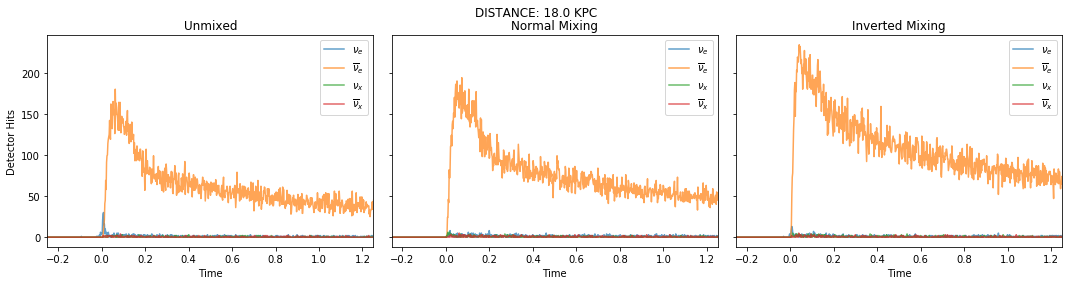

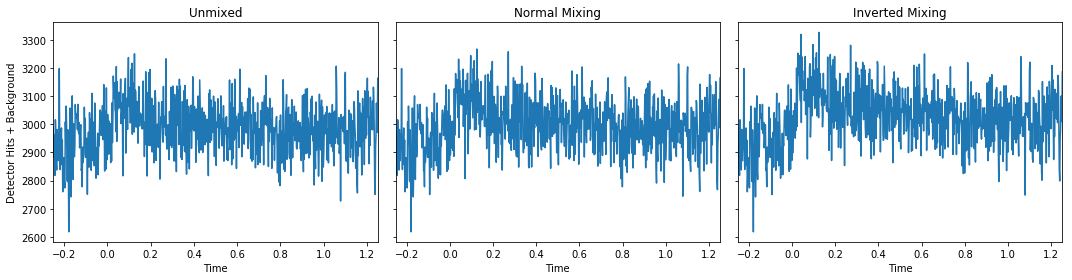

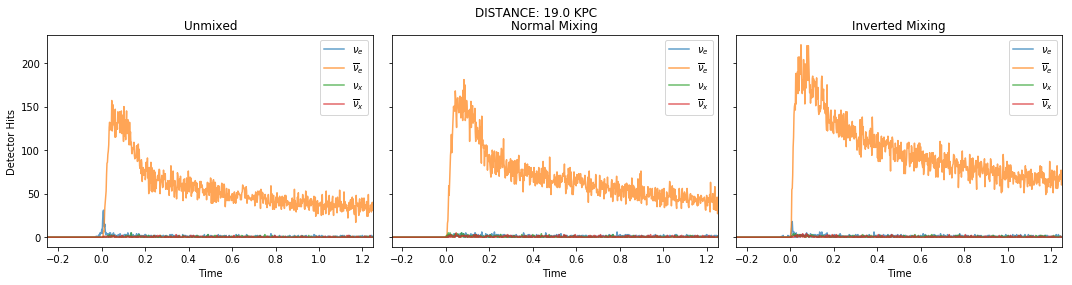

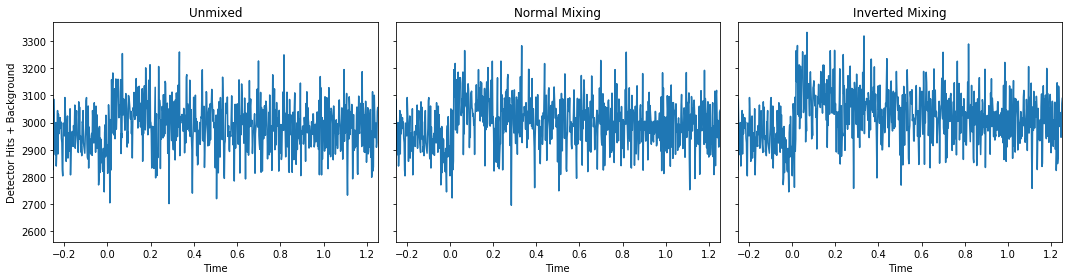

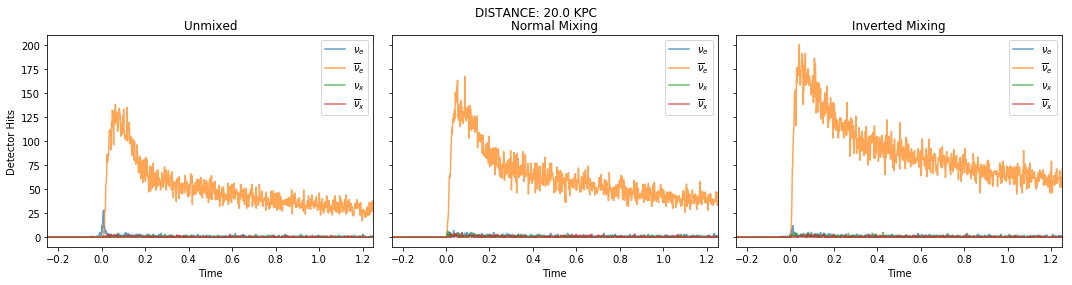

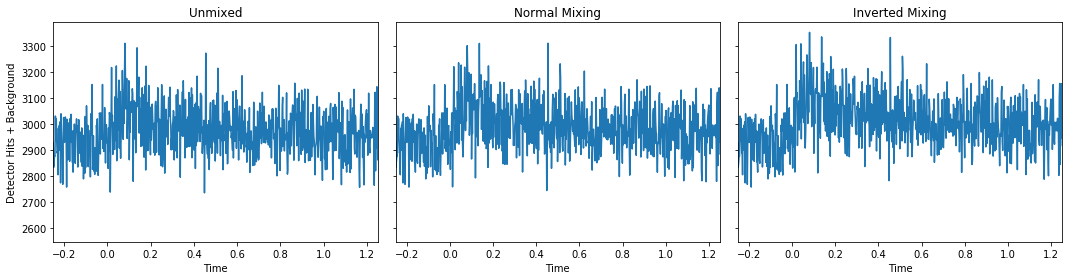

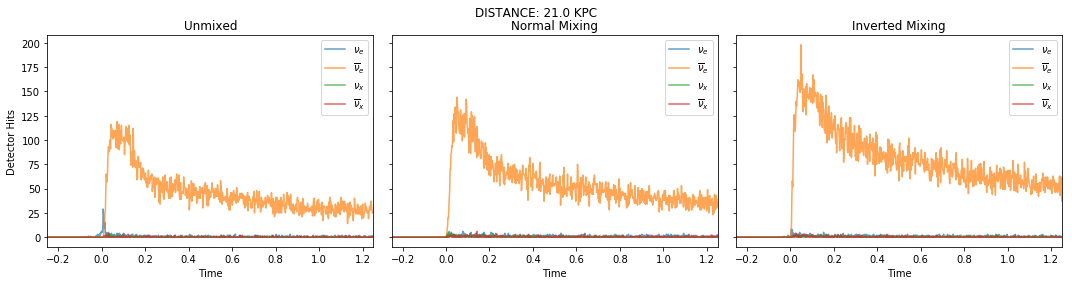

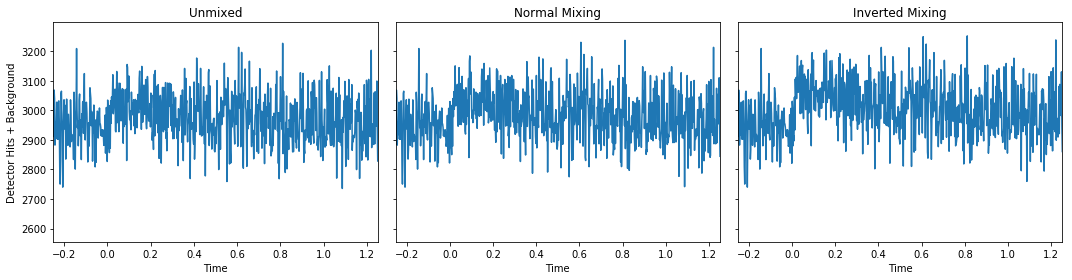

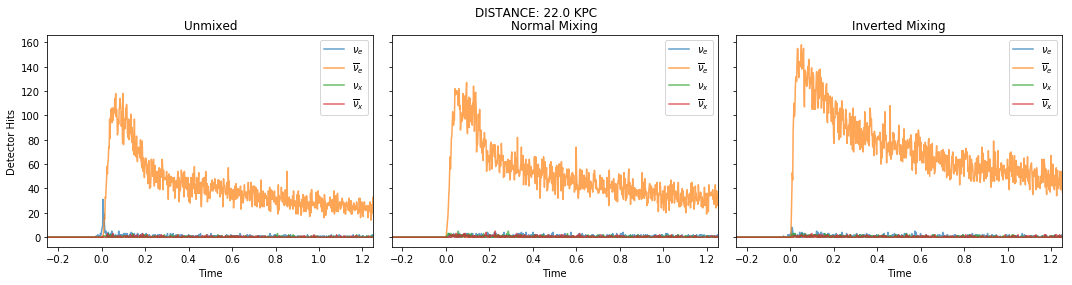

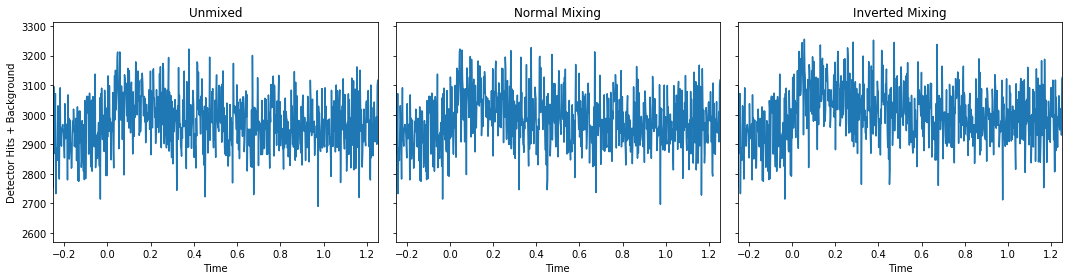

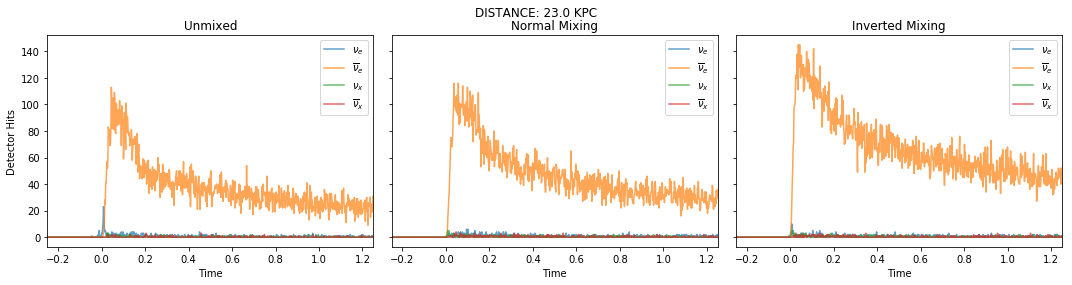

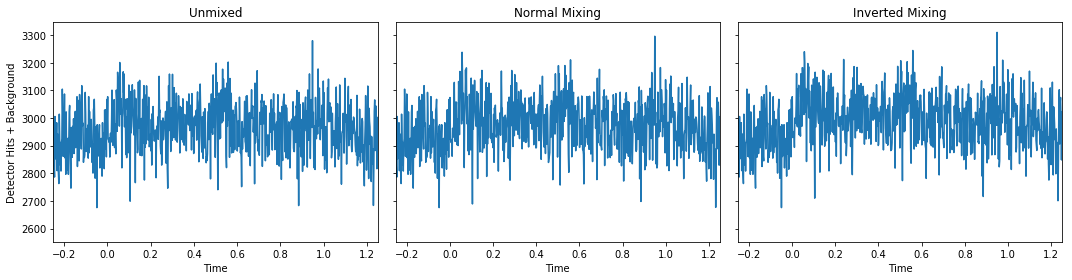

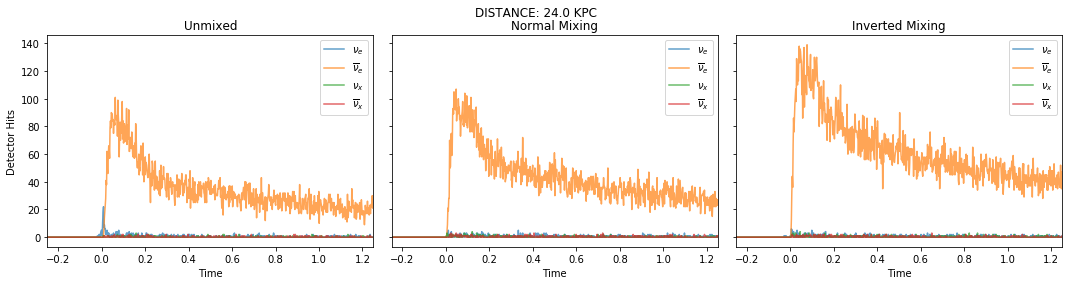

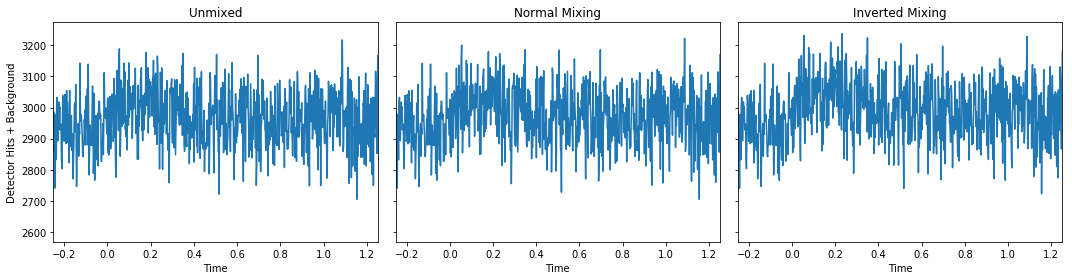

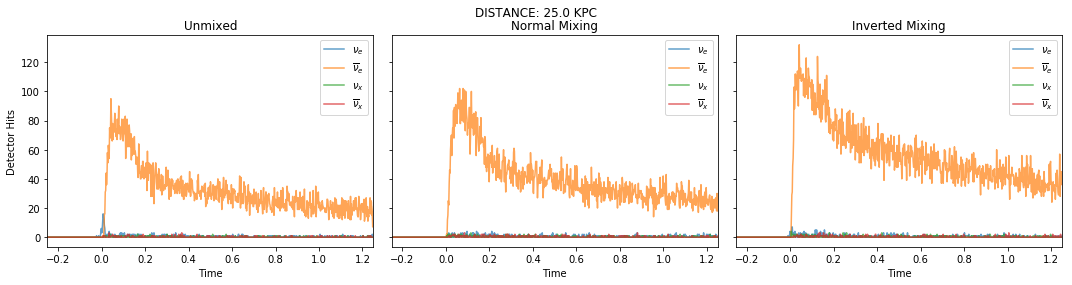

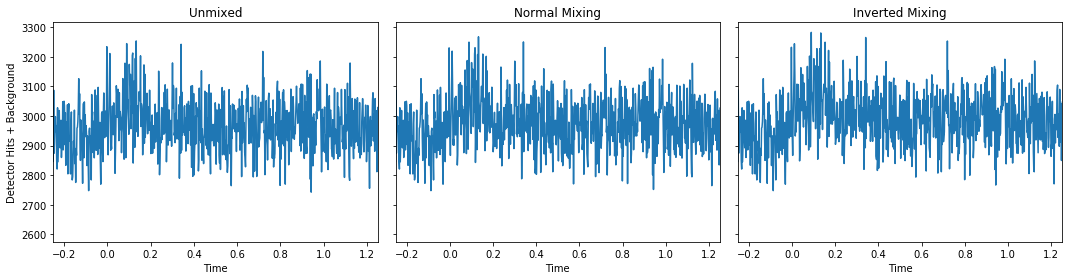

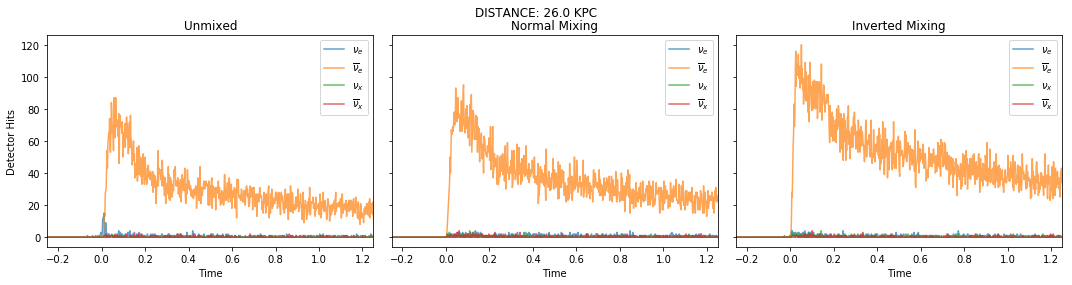

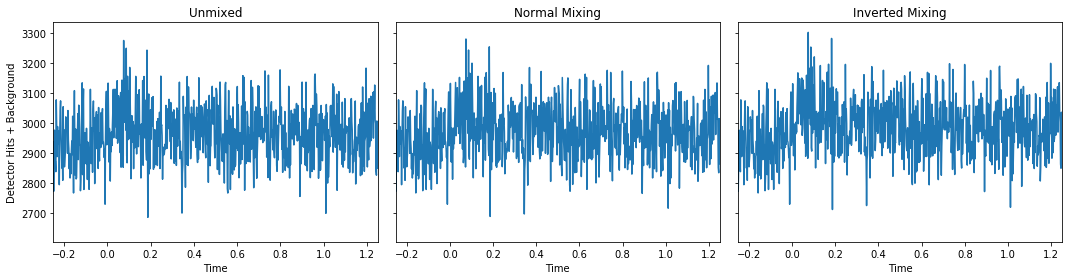

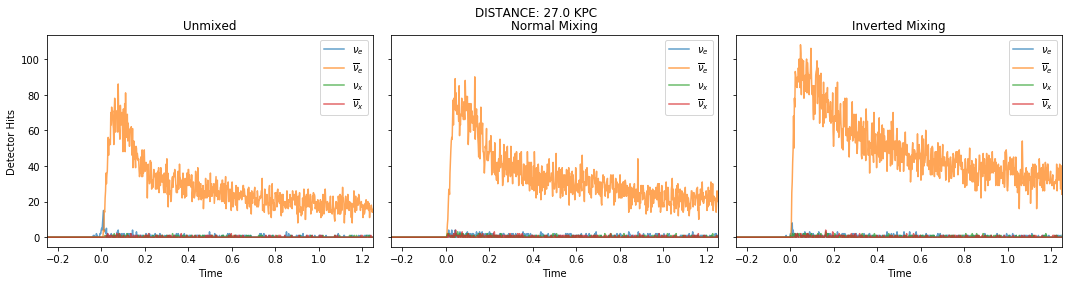

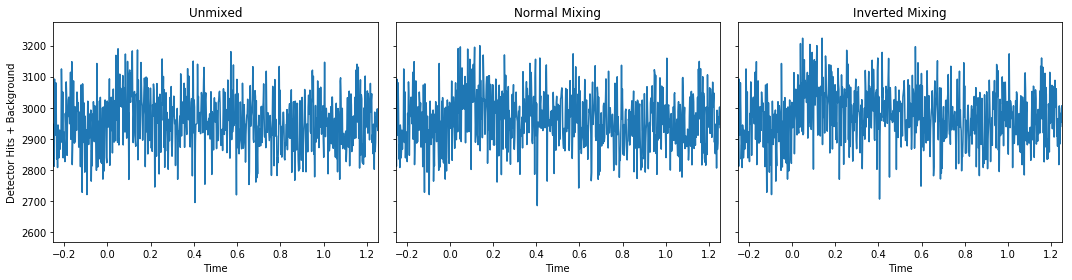

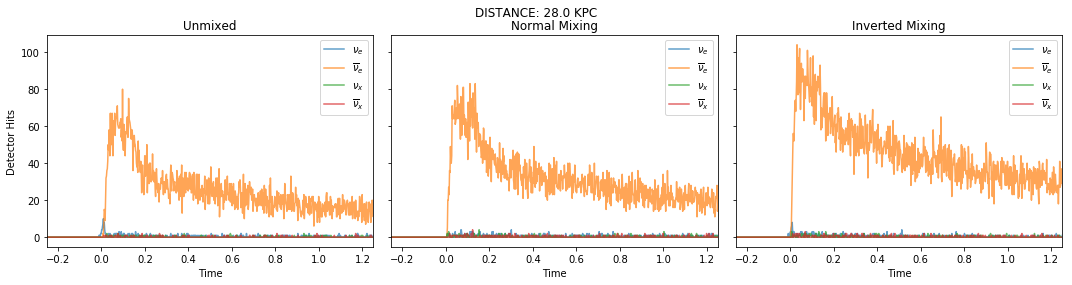

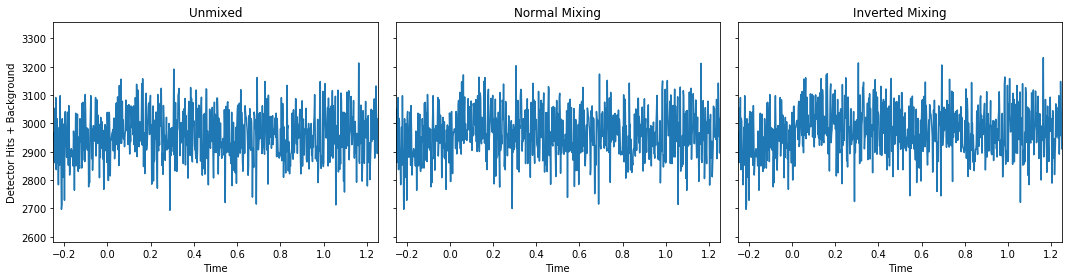

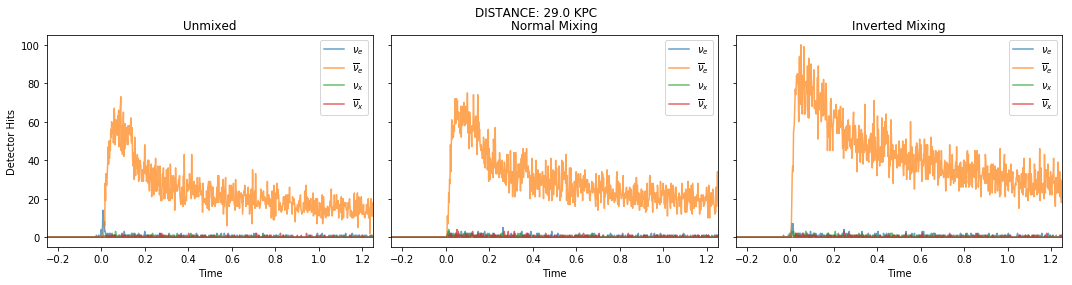

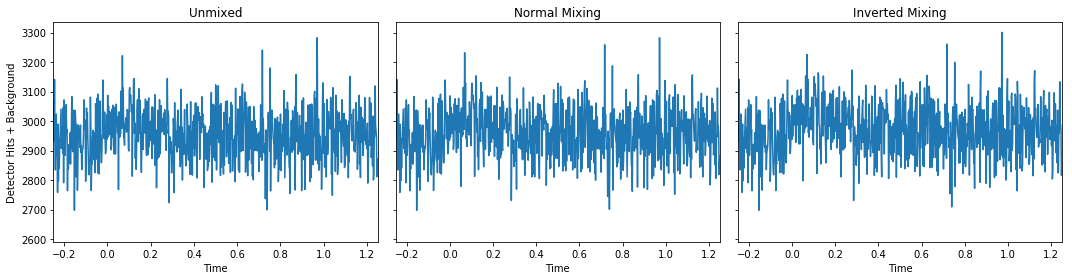

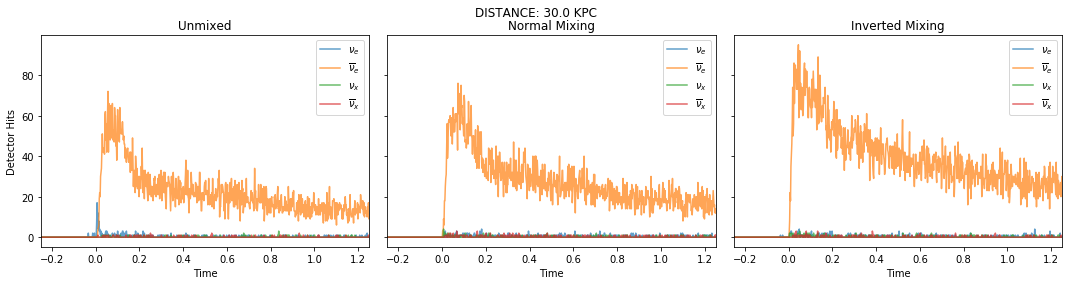

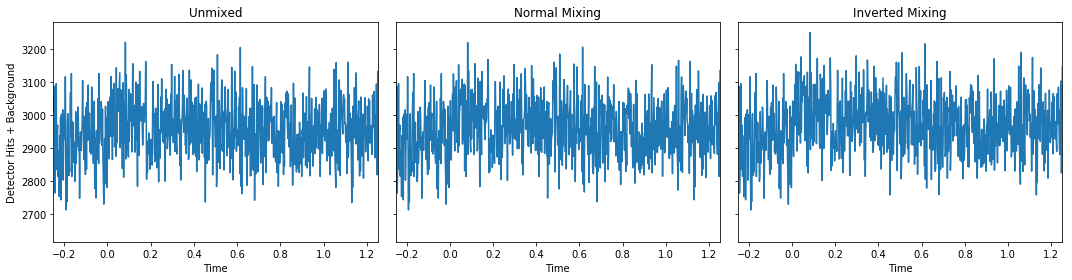

In [131]:
for d in dist:
    ccsn.progenitor_distance = d
    print('\nCalculating for {0} kpc...\n'.format(d.value))
    x = int(d.value) - 1
#     osc_data = []
#     signal_data = []
    for i, flavor in enumerate(Flavor):
#         flux = ccsn.get_flux(time, flavor)
        nu_list[i] = ccsn.get_flux(time, flavor)
    
    nu_norm = mix.normal_mixing(nu_list)
    nu_inv = mix.inverted_mixing(nu_list)

    hits_total = hits(nu_list)
    hits_norm = hits(nu_norm)
    hits_inv = hits(nu_inv)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex = True, sharey = True)
    ax1, ax2, ax3 = axes
    fig.suptitle('DISTANCE: {0} KPC'.format(d.value))
    
    for nu, flavor in enumerate(Flavor):
        astrTime, astrSignal = rebin(time, hits_total[nu], dt, icecube_dt)
#         np.savetxt('flavor_hits')
#         osc_data[0][nu] = astrSignal
#         osc_data.append([astrSignal, astrTime])
        ax1.plot(astrTime, astrSignal, label = flavor.to_tex(), alpha = 0.7)
    ax1.set(xlim=(-0.25, 1.25),
           xlabel = 'Time',
           ylabel = 'Detector Hits',
           title = 'Unmixed')
    ax1.legend()
    for nu, flavor in enumerate(Flavor):
        astrTime, astrSignal = rebin(time, hits_norm[nu], dt, icecube_dt)
#         osc_data[1][nu] = astrSignal
#         osc_data.append([astrSignal, astrTime])
        ax2.plot(astrTime, astrSignal, label = flavor.to_tex(), alpha = 0.7)
    ax2.set(xlabel = 'Time', title = 'Normal Mixing')
    ax2.legend()

    for nu, flavor in enumerate(Flavor):
        astrTime, astrSignal = rebin(time, hits_inv[nu], dt, icecube_dt)
#         osc_data[2][nu] = astrSignal
#         osc_data.append([astrSignal, astrTime])
        ax3.plot(astrTime, astrSignal, label = flavor.to_tex(), alpha = 0.7)
    ax3.set(xlabel = 'Time', title = 'Inverted Mixing')
    ax3.legend()

    fig.tight_layout()
    fig.subplots_adjust(top = 0.88)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex = True, sharey = True)
    ax1, ax2, ax3 = axes

    astrTime, astrSignal = rebin(time, sum(hits_total), dt, icecube_dt)
#     signal_data.append([astrTime, astrSignal])
#     print(len(astrTime))
#     print(data)
#     break
    bg = np.random.normal(dr, dr_er, len(astrSignal))
    ax1.plot(astrTime, astrSignal + bg)
    ax1.set(xlim=(-0.25, 1.25),
            title ='Unmixed',
            xlabel = 'Time',
            ylabel = 'Detector Hits + Background')

    astrTime, astrSignal = rebin(time, sum(hits_norm), dt, icecube_dt)
#     signal_data.append([astrTime, astrSignal])
    ax2.plot(astrTime, astrSignal + bg)
    ax2.set(title = 'Normal Mixing', xlabel = 'Time')

    astrTime, astrSignal = rebin(time, sum(hits_inv), dt, icecube_dt)
#     signal_data.append([astrTime, astrSignal])
    ax3.plot(astrTime, astrSignal + bg)
    ax3.set(title = 'Inverted Mixing', xlabel = 'Time')

    fig.tight_layout()
#     dat1.append(osc_data)
#     dat2.append(signal_data)
#     break


In [123]:
# dat1 = np.asarray(dat1)
# dat2 = np.asarray(dat2)
# print(dat1)
# print('b')
# print(dat2)

[[[[ 0.     0.     0.    ...  0.     0.     0.   ]
   [-0.999 -0.997 -0.995 ... 14.995 14.997 14.999]]

  [[ 0.     0.     0.    ...  0.     0.     0.   ]
   [-0.999 -0.997 -0.995 ... 14.995 14.997 14.999]]

  [[ 0.     0.     0.    ...  0.     0.     0.   ]
   [-0.999 -0.997 -0.995 ... 14.995 14.997 14.999]]

  ...

  [[ 0.     0.     0.    ...  0.     0.     0.   ]
   [-0.999 -0.997 -0.995 ... 14.995 14.997 14.999]]

  [[ 0.     0.     0.    ...  0.     0.     0.   ]
   [-0.999 -0.997 -0.995 ... 14.995 14.997 14.999]]

  [[ 0.     0.     0.    ...  0.     0.     0.   ]
   [-0.999 -0.997 -0.995 ... 14.995 14.997 14.999]]]]
b
[[[[-0.999 -0.997 -0.995 ... 14.995 14.997 14.999]
   [ 0.     0.     0.    ...  0.     0.     0.   ]]

  [[-0.999 -0.997 -0.995 ... 14.995 14.997 14.999]
   [ 0.     0.     0.    ...  0.     0.     0.   ]]

  [[-0.999 -0.997 -0.995 ... 14.995 14.997 14.999]
   [ 0.     0.     0.    ...  0.     0.     0.   ]]]]


In [114]:
# file = open("blaa.npz", 'ab')
# for i in range(len(dist)):
#     np.savez(file, i)
# x = np.load(file)
# print (tmp_read.files)